In this notebook I am checking the models of the datasets and if they agree, regarding Fermi and HESS

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
import os
import yaml

from gammapy.data import EventList
from gammapy.datasets import MapDataset
from gammapy.irf import PSFMap, EDispKernelMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    LogParabolaSpectralModel,
    Models,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    create_fermi_isotropic_diffuse_model,
)
from gammapy.modeling import Fit

In [2]:
import csv

names= ['Fermi', 'HESS']
colors = ['red', 'blue']
unit_y= "E"+r"$^2$"+"dN/dE (erg/cm^2/s)"
unit_x = 'eV'

flux_points = []
for name in names:
    with open(f'/home/vault/caph/mppi062h/repositories/GC/gamera/data_from_paper/{name}.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        fp_name = []
        for row in reader:
            fp_name.append(row)
    flux_points.append(np.asarray(fp_name, dtype=float))

# loading datasets

### Fermi

In [3]:
dataset_names = ['low_energy', 'med_energy', 'hi_energy']
main_path = '/home/woody/caph/mppi062h/woody_output/final/fermilat/'
iso_list = ['iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_SOURCE_V3_v1.txt']

N_bin_met = 8
radius_list = [12, 5, 5]
dataset_e_edges = [100, 600, 4e3, 1e6] #u.MeV
thresh_idx = 20

time_label=['2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']
met_values = [246823875, 309895876, 373054277, 436126277, 499284678, 562356679, 625515079, 678426195]

with open('/home/vault/caph/mppi062h/repositories/GC/FermiLAT/source_list.txt') as f:
    source_list = f.readlines()

In [4]:
def get_datasets_binmet_modelversion(modelversion):
    datasets_binmet = []
    for dataset_idx, dataset_name in enumerate(dataset_names):
        datasets_binmet.append([])
        if dataset_idx != 0:
            for n_bin_met in range(N_bin_met-1):
                folder = f'{main_path}/{dataset_name}/{n_bin_met}_bin_met'
                dataset = MapDataset.read(f'{folder}/fermi_dataset.fits', name=f'dataset_idx={dataset_idx}')

                dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
                dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, {radius_list[dataset_idx]})")

                m1 = (dataset.counts.geom.axes['energy'].center.value > dataset_e_edges[dataset_idx])
                m2 = (dataset.counts.geom.axes['energy'].center.value < dataset_e_edges[dataset_idx+1])
                mask = m1 & m2
                dataset.mask_safe.data[~mask] = 0
                
                # opening the source maps, done before
                dataset.background = Map.from_geom(geom=dataset.counts.geom, data=np.zeros_like(dataset.counts.data)) 
                for source_name in source_list[:thresh_idx]:
                    if source_name[:-1] != '4FGL J1745.6-2859':
                        temp = MapDataset.read(f'{folder}/sources_dataset/{source_name[5:-1]}.fits')
                        dataset.background.data += temp.counts.data

                if modelversion == 'separated':
                    model_file_name = 'fitted_model.yml'
                elif modelversion == 'joint':
                    model_file_name = 'fitted_model_joint.yml'
                    
                model_path = f'{main_path}/{dataset_names[dataset_idx]}/{n_bin_met}_bin_met/{model_file_name}'
                if os.path.exists(model_path):
                    dataset.models = Models.read(model_path)
                else:
                    print(dataset_idx, n_bin_met)

                datasets_binmet[dataset_idx].append(dataset)
    return datasets_binmet

In [5]:
datasets_fermi = get_datasets_binmet_modelversion(modelversion='joint')

Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr

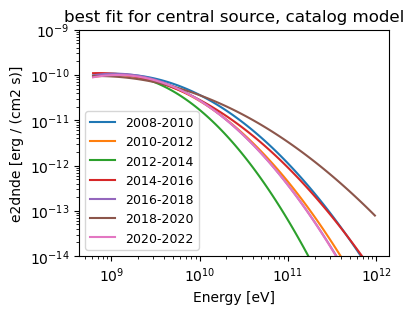

In [6]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

dataset_idx = 1

if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]

        datasets_fermi[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
            energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
plt.ylim(1e-14, 1e-9)
plt.legend(prop={'size': 9})
plt.title('best fit for central source, catalog model')
plt.show()

### HESS

In [7]:
def open_dataset(name, hessera):
    dataset= MapDataset.read(f'{mainpath_hess}/{name}.fits')
    dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, 3)")
    
    dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.71, -0.64, 0.7)")

    if hessera == 'hess1':
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(359.5, -0.2, 0.2)")
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.45, 0.15, 0.35)")

    model_path = f'{mainpath_hess}/fitted_model_{name}.yml'
    if os.path.exists(model_path):
        dataset.models = Models.read(model_path)

    return dataset

In [19]:
hesseras=['hess1', 'hess2', 'hess1u']
muoneff_flag= True
edisp = True

fp_list= []
info_list = [] #hessera, muoneff, edisp, name

mainpath_hess = '/home/vault/caph/mppi062h/repositories/GC/HESS'

for hessera in hesseras:
    if hessera =='hess1u':
        muoneff_flag=False
        
    if hessera == 'hess1':
        name_afterFermi='v1'
        for name_afterFermi_idx in range(3):
            name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}_afterFermi{name_afterFermi}_{name_afterFermi_idx}'
            info_list.append([hessera, muoneff_flag, edisp, name])
    else:
        name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}'
        info_list.append([hessera, muoneff_flag, edisp, name])
    
datasets_hess = []
for i in range(len(info_list)):
    datasets_hess.append(open_dataset(info_list[i][3], info_list[i][0])) 

# connecting the models

In [25]:
source_fermi = '4FGL J1745.6-2859'
source_hess = 'HESS J1745-290'

colors = ['darkslategrey', 'navy', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors_fp = ['red', 'blue']
labels= ['2004-2006', '2006-2008', '2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']

In [20]:
datasets = [
    [None, None, datasets_hess[0]],
    [None, None, datasets_hess[1]], 
    [datasets_fermi[1][0], datasets_fermi[2][0], datasets_hess[2]],
    [datasets_fermi[1][1], datasets_fermi[2][1], datasets_hess[2]],
    [datasets_fermi[1][2], datasets_fermi[2][2], datasets_hess[3]],
    [datasets_fermi[1][3], datasets_fermi[2][3], None],
    [datasets_fermi[1][4], datasets_fermi[2][4], None],
    [datasets_fermi[1][5], datasets_fermi[2][5], datasets_hess[4]],
    [datasets_fermi[1][6], datasets_fermi[2][6], None],
]

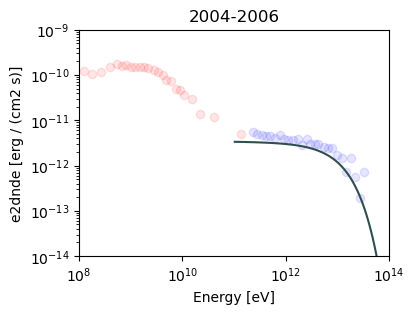

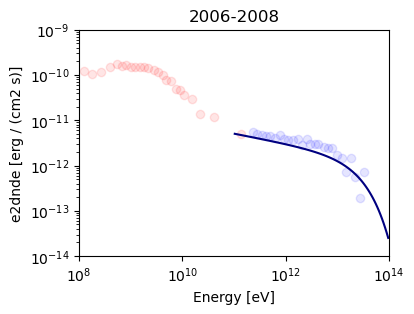

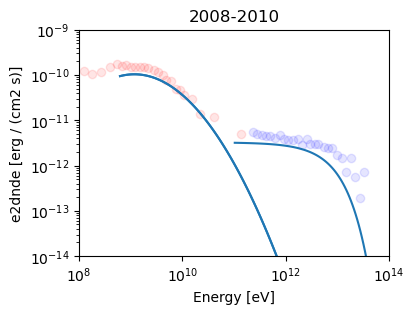

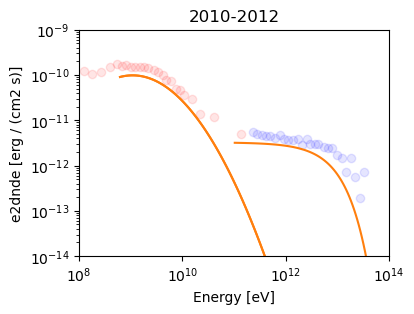

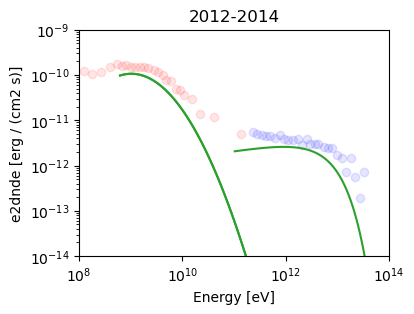

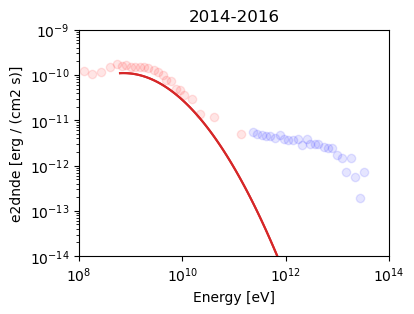

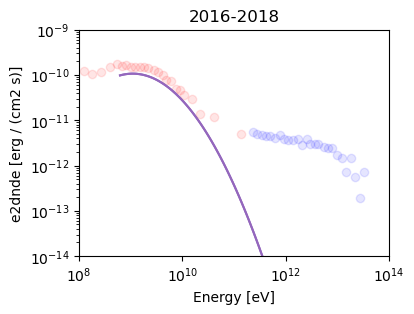

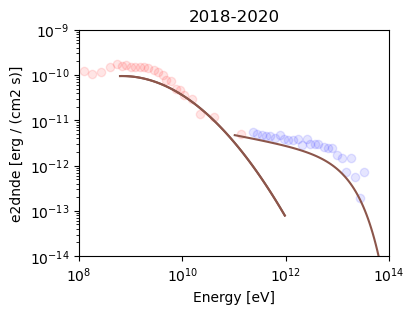

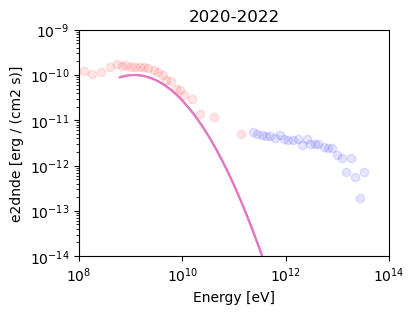

In [26]:
for idx, dataset_list in enumerate(datasets):
    fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)
    
    for idx_within, dataset in enumerate(dataset_list):
        source= source_fermi
        energy_bounds=[6e2, 1e6]*u.MeV
        sed_type="e2dnde"
        xunits=u.eV
        yunits=u.Unit("erg cm-2 s-1")
        
        if idx_within ==2:
            source = source_hess
            energy_bounds=[0.1, 1e2]*u.TeV
        if dataset != None:
            dataset.models[source].spectral_model.plot(ax=ax,
                energy_bounds=energy_bounds,sed_type=sed_type, xunits=xunits, yunits=yunits, color=colors[idx])
    for i, fp_name in enumerate(flux_points):
        ax.scatter(fp_name[:, 0], fp_name[:, 1], color=colors_fp[i], alpha=0.1)
    
    ax.set_xlim(1e8, 1e14)
    ax.set_ylim(1e-14, 1e-9)
    ax.set_title(labels[idx])
    plt.show()

# joint fit

### test with green curve

In [27]:
idx=4
dataset_fit = datasets[idx].copy()

In [40]:
for idx_within, dataset in enumerate(dataset_fit):
    if idx_within != 2:
        dataset.models = dataset.models[1:]
    else:
        dataset.

In [42]:
print(dataset_fit[2].models)

DatasetModels

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.247   +/-    0.39             
    amplitude               :   1.20e-13   +/- 6.2e-14 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0        (frozen)   :    358.277       deg         
    lat_0        (frozen)   :      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      1.827   +/-    0.11             
    amplitude               :   1.94e-12   +/- 1.8e-13 1 / (cm2 s TeV)
    reference    (fro

In [38]:
print(dataset_fit[2].models)

DatasetModels

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.247   +/-    0.39             
    amplitude               :   1.20e-13   +/- 6.2e-14 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0        (frozen)   :    358.277       deg         
    lat_0        (frozen)   :      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      1.827   +/-    0.11             
    amplitude               :   1.94e-12   +/- 1.8e-13 1 / (cm2 s TeV)
    reference    (fro

In [ ]:
from gammapy.modeling.models import CompoundSpectralModel

model = CompoundSpectralModel(pwl, lp, operator.add)